# Calculating Lin's Concordance Correlation Coefficient for predicted volumes/thicknesses

In [1]:
# imports
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk

## CCC function

In [2]:
def ccc(y_true, y_pred):
    """
    Concordance Correlation Coefficient
    """
    # means
    m1 = np.mean(y_true)
    m2 = np.mean(y_pred)

    # variances
    v1 = np.var(y_true, ddof=1)
    v2 = np.var(y_pred, ddof=1)

    # covariance
    cov = np.cov(y_true, y_pred, ddof=1)[0][1]

    # concordance correlation coefficient
    ccc = 2 * cov / (v1 + v2 + (m1 - m2) ** 2)

    return ccc

## MAE Function

In [3]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [4]:
# Mean average percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# rmse coefficient of variation (scaled by mean to become dimensionless)
def rmse_cv(y_true, y_pred):
    return 100 * np.sqrt(np.mean((y_true - y_pred) ** 2)) / np.mean(y_true)

## Function to calculate average thickness of segmentation mask

In [5]:
def average_thickness(mask: np.array, voxel_spacing: np.array):
    """
    Calculate the average thickness of a 3d mask (numpy array)
    """
    # total volume
    volume = np.sum(mask)

    # number of columns that are non-zero in x,z plane
    num_columns = np.count_nonzero(np.sum(mask, axis=(1)))

    # average thickness
    thickness = volume / num_columns

    # convert to mm
    thickness = thickness * voxel_spacing[1]

    return thickness


In [7]:
# path to predicted data
data_path = '../nnUNet_data/nnUNet_raw/Dataset361_Menisci/iwoai_internal_results/'

# list subfolders at this path
subfolders = [f.name for f in os.scandir(data_path) if f.is_dir()]
print(subfolders)

['rescale_predsTs', 'gmm_predsTs', 'ResEnc_3d_bs4_predsTs', 'clahe_predsTs', 'clip_rescale_predsTs', 'zscore_hist_match_predsTs', 'zscore_predsTs', 'hist_eq_predsTs', 'nyul_predsTs', 'ResEnc_32G_3d_predsTs']


In [8]:
# what metrics are there?
json_path = os.path.join(data_path, 'clahe_predsTs', 'summary.json')

with open(json_path) as f:
    data = json.load(f)

# extract all metrics
data["metric_per_case"][0]

{'metrics': {'1': {'Dice': 0.923939822078964,
   'FN': 4119,
   'FP': 6594,
   'Hausdorff': 3.9640698432922363,
   'Hausdorff_95': 1.011385202407837,
   'IoU': 0.8586321109512939,
   'TN': 8116219,
   'TP': 65068,
   'n_pred': 71662,
   'n_ref': 69187}},
 'prediction_file': 'clahe_predsTs/IWOAI_001.nii.gz',
 'reference_file': 'labelsTs/IWOAI_001.nii.gz'}

In [131]:
# functions to take json file and return array of segmentation volumes
def get_seg_vols(json_file):
    with open(json_file) as f:
        data = json.load(f)

    # Extract Dice scores from "metric_per_case"
    vols = [
        case["metrics"]["1"]["n_pred"] for case in data["metric_per_case"]
    ]

    return vols


def get_gt_vols(json_file):
    with open(json_file) as f:
        data = json.load(f)

    # Extract Hausdorff distances from "metric_per_case"
    vols = [
        case["metrics"]["1"]["n_ref"] for case in data["metric_per_case"]
    ]

    return vols

In [132]:
# discount folders that start with ResEnc
subfolders = [f for f in subfolders if not f.startswith("ResEnc")]

# discount hist match
subfolders = [f for f in subfolders if "hist_match" not in f]

subfolders

['rescale_predsTs',
 'gmm_predsTs',
 'clahe_predsTs',
 'clip_rescale_predsTs',
 'zscore_predsTs',
 'hist_eq_predsTs',
 'nyul_predsTs']

In [133]:
# reorder the subfolders using the order of the methods (starts with)
method_order = ["zscore_preds", "rescale", "clip_rescale", "hist_eq", "clahe_preds", "nyul", "gmm"]

# Sort by checking which method each subfolder starts with
subfolders = sorted(
    subfolders,
    key=lambda x: next((method_order.index(m) for m in method_order if x.lower().startswith(m.lower())), float('inf'))
)
subfolders

['zscore_predsTs',
 'rescale_predsTs',
 'clip_rescale_predsTs',
 'hist_eq_predsTs',
 'clahe_predsTs',
 'nyul_predsTs',
 'gmm_predsTs']

In [134]:
# for each folder, get segmentation volumes and add to pandas dataframe

# create empty dataframe
internal_df = pd.DataFrame()

for i, folder in enumerate(subfolders):
    json_path = os.path.join(data_path, folder, 'summary.json')

    if i == 0:
        gt_vols = get_gt_vols(json_path)
        internal_df['GT'] = gt_vols

    seg_vols = get_seg_vols(json_path)
    internal_df[folder] = seg_vols

column_names = [
    "GT",
    "Zscore",
    "Rescale",
    "Clip Rescale",
    "Hist Eq",
    "Clahe",
    "Nyul",
    "GMM"
]

internal_df.columns = column_names

internal_df.describe()

,GT,Zscore,Rescale,Clip Rescale,Hist Eq,Clahe,Nyul,GMM
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,59797.964286,58830.500000,58764.714286,58437.071429,58459.428571,58459.607143,58349.571429,58746.892857
std,9534.398637,9440.178865,9330.354953,9267.984578,8982.060571,8922.849289,8891.102275,9386.263234
min,36060.000000,35517.000000,35541.000000,35246.000000,35608.000000,35923.000000,36081.000000,35464.000000
25%,54123.750000,52708.250000,52777.500000,52549.250000,53194.000000,52037.750000,52232.000000,52807.500000
50%,57387.500000,58255.500000,58365.500000,57658.500000,57788.500000,58794.500000,57955.500000,58313.500000
75%,67768.500000,67168.500000,67095.250000,65792.000000,64050.500000,65446.250000,65811.250000,67378.000000
max,76810.000000,72591.000000,72428.000000,72044.000000,72818.000000,72510.000000,72630.000000,72385.000000


In [135]:
internal_df.head()

,GT,Zscore,Rescale,Clip Rescale,Hist Eq,Clahe,Nyul,GMM
0,69187,71392,71351,71817,72289,71662,72630,71319
1,71356,72591,72428,72044,72818,72510,70930,72321
2,76810,70677,70998,71258,71216,70406,69550,71067
3,75026,72373,72066,71774,72155,69306,70602,72385
4,61136,60103,59446,58595,58081,59171,59574,59913


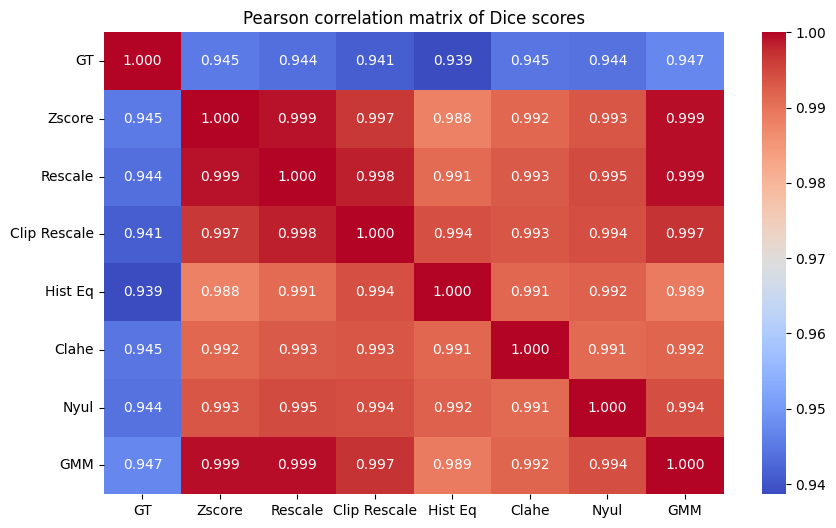

In [136]:
# plot pairwise correlation matrix of dice scores, to 3 decimal places
plt.figure(figsize=(10, 6))
sns.heatmap(internal_df.corr('pearson'), annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Pearson correlation matrix of Dice scores")
plt.show()

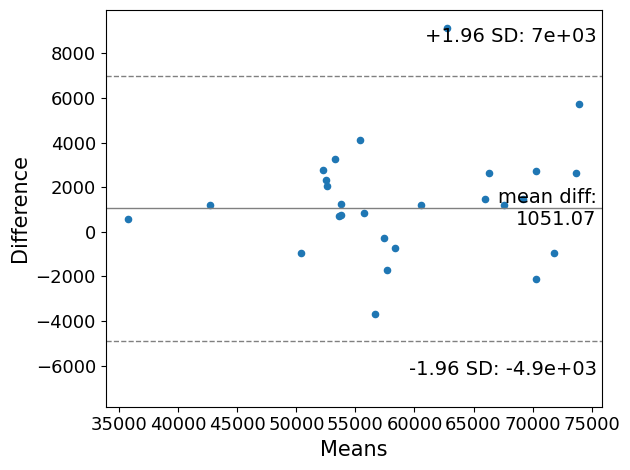

In [137]:
# plot bland-altman for zscore vs rescale (means and differences)
import statsmodels.api as sm
sm.graphics.mean_diff_plot(internal_df["GT"], internal_df["GMM"])
#plt.savefig('bland_altman_zscore_rescale.eps', format='eps', bbox_inches='tight')
plt.show()

In [138]:
# calculate CCC and MAE for each method
ccc_scores = []
mae_scores = []

for method in column_names[1:]:
    ccc_scores.append(ccc(internal_df["GT"], internal_df[method]))
    mae_scores.append(mean_absolute_error(internal_df["GT"], internal_df[method]))

# create dataframe of scores
scores_df = pd.DataFrame({
    "Method": column_names[1:],
    "CCC": ccc_scores,
    "MAE": mae_scores
})

scores_df

,Method,CCC,MAE
0,Zscore,0.940311,2339.035714
1,Rescale,0.937692,2436.178571
2,Clip Rescale,0.930962,2690.392857
3,Hist Eq,0.927294,2743.321429
4,Clahe,0.932649,2681.214286
5,Nyul,0.930347,2637.250000
6,GMM,0.941251,2385.500000


## Do average thickness now

In [142]:
# load in first mask of first method to test
import glob

# get all mask paths
masks_paths = glob.glob(os.path.join(data_path, subfolders[0]) + '/*.nii.gz')
masks_paths.sort()
masks_paths[:5]

['../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/iwoai_internal_results/zscore_predsTs/IWOAI_001.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/iwoai_internal_results/zscore_predsTs/IWOAI_002.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/iwoai_internal_results/zscore_predsTs/IWOAI_003.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/iwoai_internal_results/zscore_predsTs/IWOAI_004.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/iwoai_internal_results/zscore_predsTs/IWOAI_005.nii.gz']

(256, 200, 160)
(0.36500000953674316, 0.36500000953674316, 0.699999988079071)
(160, 200, 256)
[0.69999999 0.36500001 0.36500001]


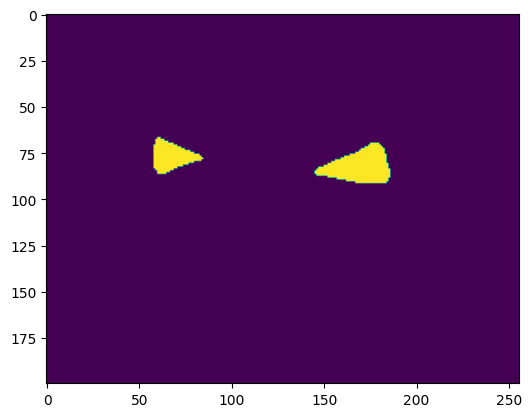

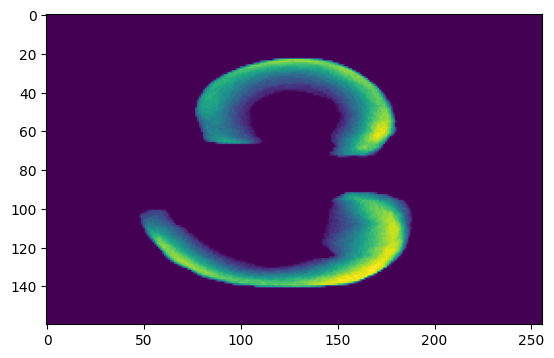

Average Thickness: 4.26 mm


In [191]:
# load in first mask
mask = sitk.ReadImage(masks_paths[0])

# print mask info
print(mask.GetSize())
print(mask.GetSpacing())

# convert mask to numpy array
mask_np = sitk.GetArrayFromImage(mask)
print(mask_np.shape)

# get spacing in numpy array format and reverse to match sitk to numpy conversion
np_spacing = np.array(mask.GetSpacing())[::-1]
print(np_spacing)

# show slice of mask
plt.imshow(mask_np[120,...])
plt.show()

# show mask collapsed in up-down direction
collapsed_mask = np.sum(mask_np, axis=1)
plt.imshow(collapsed_mask)
plt.show()

# number of columns that are non-zero in x,z plane
num_columns = np.count_nonzero(collapsed_mask)

# total volume
volume = np.sum(collapsed_mask)

# average thickness
thickness = volume / num_columns
thickness = thickness * np_spacing[1]
print("Average Thickness: {:.2f} mm".format(thickness))

In [193]:
# check function
average_thickness(mask_np, np_spacing).round(2)

4.26

In [198]:
# calculate average thickness for all GT masks
gt_masks_paths = glob.glob(os.path.join(data_path, '../labelsTs', '*.nii.gz'))
gt_masks_paths.sort()

average_thicknesses = []

for mask_path in gt_masks_paths:
    mask = sitk.ReadImage(mask_path)
    mask_np = sitk.GetArrayFromImage(mask)
    np_spacing = np.array(mask.GetSpacing())[::-1]
    thickness = average_thickness(mask_np, np_spacing)
    average_thicknesses.append(thickness)

# create dataframe of average thicknesses
thickness_df = pd.DataFrame({
    "GT": average_thicknesses
})

from tqdm import tqdm

# now calculate average thickness for all predicted masks of all methods
for folder in tqdm(subfolders):
    masks_paths = glob.glob(os.path.join(data_path, folder) + '/*.nii.gz')
    masks_paths.sort()

    average_thicknesses = []

    for mask_path in masks_paths:
        mask = sitk.ReadImage(mask_path)
        mask_np = sitk.GetArrayFromImage(mask)
        np_spacing = np.array(mask.GetSpacing())[::-1]
        thickness = average_thickness(mask_np, np_spacing)
        average_thicknesses.append(thickness)

    thickness_df[folder] = average_thicknesses

100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:15<00:00,  2.23s/it]


In [201]:
# rename columns
thickness_df.columns = column_names

# describe dataframe
thickness_df.describe()

,GT,Zscore,Rescale,Clip Rescale,Hist Eq,Clahe,Nyul,GMM
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,3.801383,3.827256,3.828452,3.821734,3.810063,3.827186,3.818049,3.825908
std,0.330006,0.302276,0.303246,0.304599,0.312271,0.296507,0.299646,0.300797
min,3.072339,3.091749,3.081346,3.080649,3.099671,3.089514,3.092173,3.085664
25%,3.601206,3.667287,3.664184,3.648248,3.584588,3.646768,3.654101,3.663847
50%,3.830744,3.844063,3.845387,3.842039,3.819860,3.832765,3.832327,3.841676
75%,4.000103,3.958782,3.970384,3.986714,3.979852,3.989306,3.959437,3.965225
max,4.412284,4.369194,4.384746,4.372024,4.384926,4.333740,4.344922,4.370641


In [203]:
# do CCC and MAE for average thickness
ccc_scores = []
mae_scores = []

for method in column_names[1:]:
    ccc_scores.append(ccc(thickness_df["GT"], thickness_df[method]))
    mae_scores.append(mean_absolute_error(thickness_df["GT"], thickness_df[method]))

# create dataframe of scores
thickness_scores_df = pd.DataFrame({
    "Method": column_names[1:],
    "CCC": ccc_scores,
    "MAE": mae_scores
})

thickness_scores_df

,Method,CCC,MAE
0,Zscore,0.916555,0.101627
1,Rescale,0.912416,0.104399
2,Clip Rescale,0.907709,0.106604
3,Hist Eq,0.892984,0.117753
4,Clahe,0.913189,0.109303
5,Nyul,0.910622,0.105999
6,GMM,0.915042,0.102512


# Do External Validation on whole of SKMTEA

In [204]:
data_path = '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/skmtea_external_results/'

# get only the subfolders that end in _all_skmtea
subfolders = [f.name for f in os.scandir(data_path) if f.is_dir() and f.name.endswith("_all_skmtea")]

# discount images and labels folders (starts with)
subfolders = [f for f in subfolders if not f.startswith("images") and not f.startswith("labels") 
              and not f.startswith("ResEnc") and not f.startswith("clahe_hist_match")
              and not f.startswith("zscore_postproc") and "hist_match" not in f]
subfolders

['gmm_preds_all_skmtea',
 'clahe_preds_all_skmtea',
 'nyul_preds_all_skmtea',
 'zscore_preds_all_skmtea',
 'hist_eq_preds_all_skmtea',
 'clip_rescale_preds_all_skmtea',
 'rescale_preds_all_skmtea']

In [205]:
# reorder the subfolders using the order of the methods (starts with)
method_order = ["zscore_preds", "rescale", "clip_rescale", "hist_eq", "clahe_preds", "resenc", "nyul", "gmm"]
# Sort by checking which method each subfolder starts with
subfolders = sorted(
    subfolders,
    key=lambda x: next((method_order.index(m) for m in method_order if x.lower().startswith(m.lower())), float('inf'))
)
subfolders

['zscore_preds_all_skmtea',
 'rescale_preds_all_skmtea',
 'clip_rescale_preds_all_skmtea',
 'hist_eq_preds_all_skmtea',
 'clahe_preds_all_skmtea',
 'nyul_preds_all_skmtea',
 'gmm_preds_all_skmtea']

In [206]:
# for each folder, get dice scores and add to pandas dataframe

# create empty dataframe
external_all_df = pd.DataFrame()

for i, folder in enumerate(subfolders):
    json_path = os.path.join(data_path, folder, 'summary.json')

    if i == 0:
        gt_vols = get_gt_vols(json_path)
        external_all_df['GT'] = gt_vols
    
    seg_vols = get_seg_vols(json_path)
    external_all_df[folder] = seg_vols

external_all_df.head()

,GT,zscore_preds_all_skmtea,rescale_preds_all_skmtea,clip_rescale_preds_all_skmtea,hist_eq_preds_all_skmtea,clahe_preds_all_skmtea,nyul_preds_all_skmtea,gmm_preds_all_skmtea
0,54907,46436,46711,46319,47371,46860,46603,46460
1,58418,68246,68121,68267,69448,68068,69956,67931
2,52353,46130,46150,45345,45523,44946,46861,46005
3,62179,73021,73423,72950,73341,71800,73757,73321
4,60775,61388,61176,61363,61837,61113,63647,61041


In [207]:
# rename columns
external_all_df.columns = [
    "GT",
    "Zscore",
    "Rescale",
    "Clip Rescale",
    "Hist Eq",
    "Clahe",
    "Nyul",
    "GMM"
]

In [208]:
external_all_df.describe()

,GT,Zscore,Rescale,Clip Rescale,Hist Eq,Clahe,Nyul,GMM
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,54100.625806,52784.670968,52710.135484,52385.148387,53151.858065,52786.270968,54076.419355,52522.974194
std,16382.040566,14230.804857,14262.986875,14172.088584,14011.808152,14202.309344,14220.186739,14352.547079
min,14027.000000,14754.000000,14175.000000,13657.000000,16712.000000,15574.000000,16523.000000,13604.000000
25%,41468.500000,43588.000000,43685.000000,43772.500000,43940.000000,43190.000000,42437.000000,43508.500000
50%,52751.000000,51455.000000,51051.000000,51178.000000,52175.000000,51623.000000,52880.000000,51082.000000
75%,62905.000000,61964.000000,61690.500000,61214.500000,62072.000000,61490.000000,63521.500000,61698.000000
max,116412.000000,96586.000000,98119.000000,97212.000000,94865.000000,94531.000000,92983.000000,99300.000000


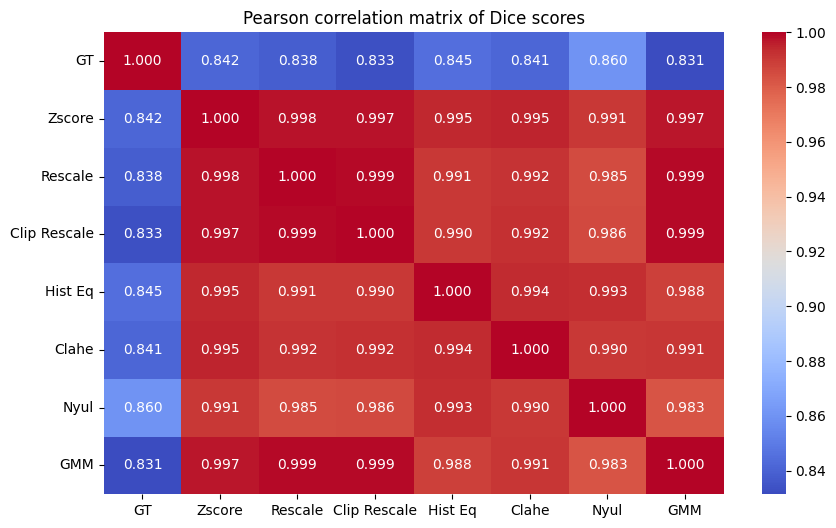

In [209]:
# plot pairwise correlation matrix of dice scores, to 3 decimal places
plt.figure(figsize=(10, 6))
sns.heatmap(external_all_df.corr('pearson'), annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Pearson correlation matrix of Dice scores")
plt.show()

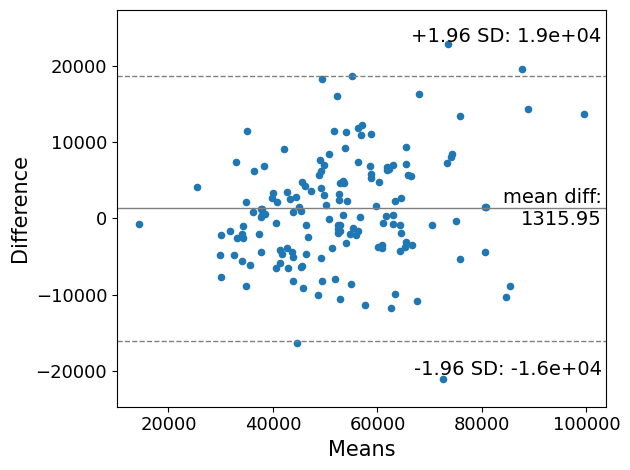

In [224]:
# bland-altman plot for zscore and zscore hist match
sm.graphics.mean_diff_plot(external_all_df["GT"], external_all_df["Zscore"])
plt.show()

In [211]:
# calculate CCC and MAE for each method
ccc_scores = []
mae_scores = []

for method in column_names[1:]:
    ccc_scores.append(ccc(external_all_df["GT"], external_all_df[method]))
    mae_scores.append(mean_absolute_error(external_all_df["GT"], external_all_df[method]))

# create dataframe of scores
external_scores_df = pd.DataFrame({
    "Method": column_names[1:],
    "CCC": ccc_scores,
    "MAE": mae_scores
})

external_scores_df

,Method,CCC,MAE
0,Zscore,0.830350,6189.103226
1,Rescale,0.826840,6352.929032
2,Clip Rescale,0.819223,6370.096774
3,Hist Eq,0.833085,6178.290323
4,Clahe,0.829913,6118.032258
5,Nyul,0.851414,6006.425806
6,GMM,0.819861,6400.129032


### Thickness

In [212]:
# calculate average thickness for all GT masks
gt_masks_paths = glob.glob(os.path.join(data_path, '../labels_all_skmtea', '*.nii.gz'))
gt_masks_paths.sort()

average_thicknesses = []

for mask_path in gt_masks_paths:
    mask = sitk.ReadImage(mask_path)
    mask_np = sitk.GetArrayFromImage(mask)
    np_spacing = np.array(mask.GetSpacing())[::-1]
    thickness = average_thickness(mask_np, np_spacing)
    average_thicknesses.append(thickness)

# create dataframe of average thicknesses
thickness_df = pd.DataFrame({
    "GT": average_thicknesses
})

# now calculate average thickness for all predicted masks of all methods
for folder in tqdm(subfolders):
    masks_paths = glob.glob(os.path.join(data_path, folder) + '/*.nii.gz')
    masks_paths.sort()

    average_thicknesses = []

    for mask_path in masks_paths:
        mask = sitk.ReadImage(mask_path)
        mask_np = sitk.GetArrayFromImage(mask)
        np_spacing = np.array(mask.GetSpacing())[::-1]
        thickness = average_thickness(mask_np, np_spacing)
        average_thicknesses.append(thickness)

    thickness_df[folder] = average_thicknesses

100%|██████████████████████████████████████████████████████████████████████████| 7/7 [01:57<00:00, 16.72s/it]


In [217]:
# rename columns
thickness_df.columns = column_names

# describe dataframe
thickness_df.describe()

,GT,Zscore,Rescale,Clip Rescale,Hist Eq,Clahe,Nyul,GMM
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,3.204921,3.266384,3.275218,3.260081,3.292131,3.253453,3.331103,3.268894
std,0.377569,0.354634,0.360432,0.357335,0.343928,0.353821,0.344005,0.359848
min,2.372740,2.432043,2.412119,2.409121,2.449790,2.391914,2.491856,2.419987
25%,2.957273,3.034451,3.043718,3.023465,3.043620,3.010334,3.085761,3.041281
50%,3.181038,3.280059,3.303377,3.271916,3.302679,3.257037,3.345030,3.283070
75%,3.444295,3.483985,3.490613,3.471773,3.504801,3.477298,3.524124,3.490266
max,4.448788,4.441735,4.477539,4.436316,4.435404,4.462663,4.453891,4.492074


In [218]:
# do CCC and MAE for average thickness
ccc_scores = []
mae_scores = []

for method in column_names[1:]:
    ccc_scores.append(ccc(thickness_df["GT"], thickness_df[method]))
    mae_scores.append(mean_absolute_error(thickness_df["GT"], thickness_df[method]))

# create dataframe of scores
thickness_scores_df = pd.DataFrame({
    "Method": column_names[1:],
    "CCC": ccc_scores,
    "MAE": mae_scores
})

thickness_scores_df

,Method,CCC,MAE
0,Zscore,0.842037,0.158751
1,Rescale,0.838723,0.163905
2,Clip Rescale,0.839635,0.160951
3,Hist Eq,0.828654,0.166082
4,Clahe,0.846098,0.155514
5,Nyul,0.811157,0.179836
6,GMM,0.838641,0.162919


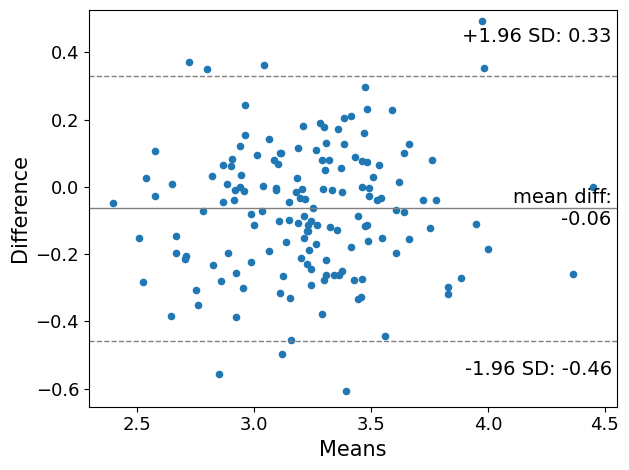

In [221]:
# bland-altman plot for GT and Nyul
sm.graphics.mean_diff_plot(thickness_df["GT"], thickness_df["GMM"])
plt.show()

In [222]:
# mae as a percentage of the mean thickness
for method in column_names[1:]:
    mean_thickness = np.mean(thickness_df["GT"])
    mae = mean_absolute_error(thickness_df["GT"], thickness_df[method])
    mae_percentage = (mae / mean_thickness) * 100
    print(f"{method}: {mae_percentage:.2f}%")

Zscore: 4.95%
Rescale: 5.11%
Clip Rescale: 5.02%
Hist Eq: 5.18%
Clahe: 4.85%
Nyul: 5.61%
GMM: 5.08%


In [223]:
# mae as a percentage of the mean volume
for method in column_names[1:]:
    mean_volume = np.mean(external_all_df["GT"])
    mae = mean_absolute_error(external_all_df["GT"], external_all_df[method])
    mae_percentage = (mae / mean_volume) * 100
    print(f"{method}: {mae_percentage:.2f}%")

Zscore: 11.44%
Rescale: 11.74%
Clip Rescale: 11.77%
Hist Eq: 11.42%
Clahe: 11.31%
Nyul: 11.10%
GMM: 11.83%
